In [ ]:
# ..... cross-species and cross-stage coexp cons ..... #

In [2]:
library(dplyr)

get_top_pairs_mat <- function (mat.rank, n){ 
  f = mat.rank>dim(mat.rank)[1]-n
  mat.pairs = mat.rank*0
  mat.pairs[f] = 1
  return(mat.pairs)
}    

auroc_analytic2 <-function (mat, np, nL) { 
  ranks = 1:nL
  mini = sum(ranks[1:np])
  maxi = sum(ranks[(nL-np+1):nL])    
  range = maxi - mini    
  auroc <- (mat - mini)/range
  return(auroc)
}

roc_bg_predict <- function (bg_predict_res, species1, species2, np, nL){
  rocs = matrix(0, ncol = 2, nrow = dim(bg_predict_res[[1]])[2])
  colnames(rocs) = c(species1,species2)
  #   rownames(rocs) = rownames(bg_predict_res[[1]])
  
  ranks = 1:nL
  mini = sum(ranks[1:np])
  maxi = sum(ranks[(nL-np+1):nL])    
  range = maxi - mini
  
  for(i in 1:2){
    temp = t(apply(bg_predict_res[[i]], 1, function(x) rank(x, ties.method = "average")))        
    rocs[,i] <- (diag(temp) - mini)/range       
  }
  return(rocs)
}

In [53]:
# get orthologs
# om = read.delim('turtle/turtle_chicken_orthologs_biomart.txt', sep = '\t')
# om <- om[which(om[,1]!='' & om[,2]!='' & !is.na(om[,5]) & om[,5]==1 & om[,4]=='ortholog_one2one'),]

om = read.delim('lizard/lizard_chicken_orthologs_eggNOG.txt', sep = '\t')
om <- om[which(!is.na(om$lizard_gene) & !is.na(om$ortholog_name)),]
om <- om[,c('lizard_gene', 'ortholog_name')]
dim(om)
om[1,]

[1] 25708     2

lizard_gene ortholog_name
1 ARHGEF10    ARHGEF10

In [54]:
v1 = c('stage23', 'stage28', 'stage32')  # chicken
v2 = c('stage14', 'stage17', 'stage21')  # turtle
v3 = c('stage9', 'stage13', 'stage16')  # lizard
df = data.frame(list1 = rep(v1, each = 3), list2 = rep(v3, 3))
df[1:2,]

list1   list2  
1 stage23 stage9 
2 stage23 stage13

In [55]:
sp1 = 'chicken'
sp2 = 'lizard'
pb = txtProgressBar(min = 0, max = 9, initial = 0)

for(ii in 1:9){
    
    # load coexp data
    stage1 = df$list1[ii]    
    stage2 = df$list2[ii]

    spestage1 = paste0(sp1, '_', stage1)
    spestage2 = paste0(sp2, '_', stage2)

    load(paste0(sp1, '/', sp1, '_', stage1, '_coexp_net.Rdata'))
    coexp_species1 = cor1
    load(paste0(sp2, '/', sp2, '_', stage2, '_coexp_net.Rdata'))
    coexp_species2 = cor1
    
    # rename chicken data gene names
    rownames(coexp_species1) <- om[match(rownames(coexp_species1), om[,2]),1]
    keep_ids = which(!is.na(rownames(coexp_species1)))
    coexp_species1 <- coexp_species1[keep_ids,keep_ids]
    
    # subset to common orthologs
    common_genes = unique(intersect(rownames(coexp_species1), rownames(coexp_species2)))
    # length(common_genes)
    id1 = match(common_genes, rownames(coexp_species1))
    coexp_species1 <- coexp_species1[id1, id1]
    id2 = match(common_genes, rownames(coexp_species2)) 
    coexp_species2 <- coexp_species2[id2, id2]
    
    
    # ................................................. #
    # calculate ranks and top 10s
    rank_species1 = apply(coexp_species1, 1, rank, ties.method = 'average')
    rank_species2 = apply(coexp_species2, 1, rank, ties.method = 'average')

    mat1 = get_top_pairs_mat(t(rank_species1), 10)
    mat2 = get_top_pairs_mat(t(rank_species2), 10)

    gg_sp12 = mat1%*%rank_species2    # sp1 genes predict sp2 genes this well
    gg_sp21 = mat2%*%rank_species1    # sp2 genes predict sp1 genes this well

    res.mat1 = auroc_analytic2(gg_sp12, 10, dim(mat1)[2])
    res.mat2 = auroc_analytic2(gg_sp21, 10, dim(mat2)[2])
    res = vector("list", length = 2)
    res[[1]] = res.mat1
    res[[2]] = res.mat2


    # function conservation and specificity scores #
    fncons_aurocs = matrix(0, ncol = 2, nrow = dim(res[[1]])[2])
    colnames(fncons_aurocs) = c(spestage2, spestage1)
    fncons_aurocs[,1] = diag(res.mat1)
    fncons_aurocs[,2] = diag(res.mat2)

    spec_aurocs = roc_bg_predict(res, spestage2, spestage1, 1, dim(mat1)[1])

    geneList = cbind(rownames(coexp_species1), rownames(coexp_species2))
    colnames(geneList) = c(spestage1, spestage2)

    roc_scores = data.frame(geneList, rowMeans(fncons_aurocs), rowMeans(spec_aurocs))
    colnames(roc_scores) <- c('sp1_gene', 'sp2_gene', 'fc', 'sc')

    # save
    fileo = paste0(spestage1, '_', spestage2, '_pseudobulk_coexp_cons.csv')
    write.table(roc_scores, file = fileo, sep = ',', row.names = F, col.names = T, quote = F)
    
    setTxtProgressBar(pb, ii)
}

[1] 10108     4

sp1_gene sp2_gene fc        sc       
7954 TBX5     TBX5     0.7522678 0.9621055

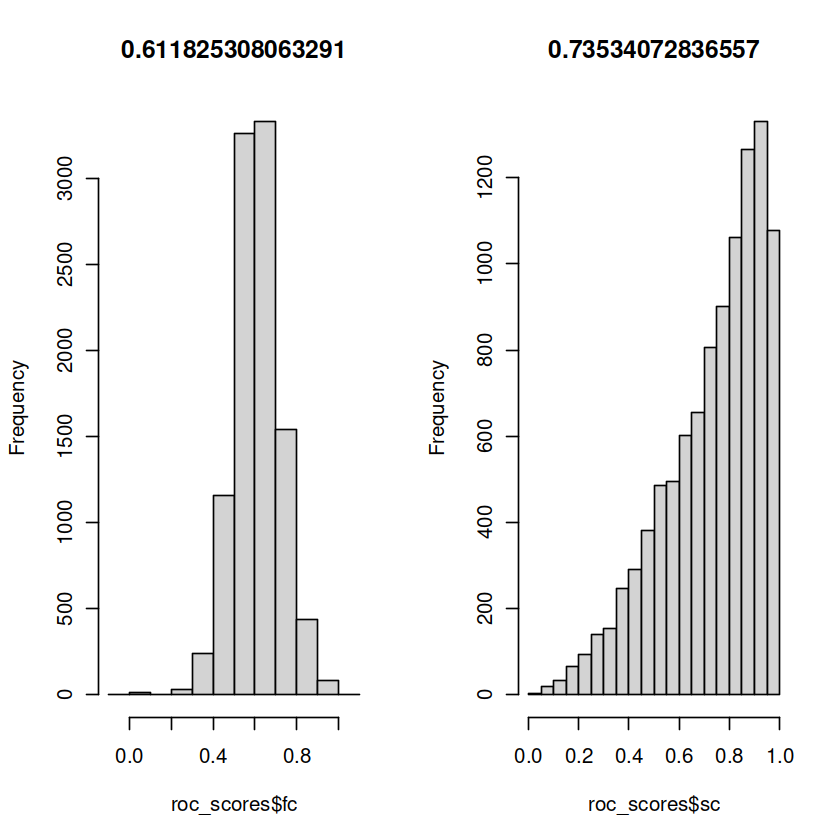

In [56]:
dim(roc_scores)
roc_scores[match('TBX5', roc_scores[,2]),]

par(mfrow=c(1,2))
hist(roc_scores$fc, main = mean(roc_scores$fc, na.rm = T))
hist(roc_scores$sc, main = mean(roc_scores$sc, na.rm = T))